### Augment the PythonPath so python can find necessary code.

In [1]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

### Import useful python packages

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import tqdm
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### Load the data

passivity_2p_imaging_utils provides a list of all the datasets and provides a helper class to make loading the data easy.

The data_sets are split into three conditions... (the keynames are wierd for historical reasons)   
'enp': control group - no shocks at all.  
'c': experimental group - fish experience behavioral challenge (repeated shocks) while being imaged  
'e': reexposed group - first fish experience free-swimming behavioral challenge... then are imaged during behavioral challenge
  
all_data is a dictionary keyed by the condition.  
all_data[condition] contains a list of Passivity_2p_Fish objects.

In [3]:
import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

print 'controls, n =', len(all_data['enp'])
print 'experimental, n =', len(all_data['c'])
print 'reexposed, n =', len(all_data['e'])

controls, n = 6
experimental, n = 8
reexposed, n = 12


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Some ideal example fish for modeling
(see 2p_Fish_Figure3_Accumulation.ipynb)

In [4]:
print 'experimental', all_data['c'][6].fishid
print 'reexposed', all_data['e'][2].fishid

experimental f01606
reexposed f01555


### Passivity_2p_Fish Class

The `Passivity_2p_Fish` class offers various members and methods for loading data associated with each fish.  
  
Lets demo these methods using an example fish:  

In [5]:
f = all_data['e'][2]

The time of all volumes, tail_movements, and shocks are stored in the following variable:

In [7]:
print 'The first shock started at t=', f.shock_st[0], 's'#shock start times
print 'The first slice of the frame began being imaged at t=', f.frame_st[0,0], 's' #time at which each slice was imaged [#samples X #slices]
print 'The first tail movement started at=', f.tail_movement_start_times[0], 's' #tail movement times - movements separted into forward swims, turns and escapes.
print 'Num z-planes imaged:', f.num_zplanes
print 'Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean() #frame_st is #frames x #slices, we examine interval between imaging first slice

The first shock started at t= 448.9964299699543 s
The first slice of the frame began being imaged at t= 12.446 s
The first tail movement started at= 102.5907 s
Num z-planes imaged: 11
Volume-Rate: 1.0131832172386757


Demo code for examining movie of tail (slowed by factor of 10)

In [6]:
movement_ndx = 10
clip = f.get_tail_movie_clip(f.tail_movement_start_times[movement_ndx]-.1, 
                             f.tail_movement_end_times[movement_ndx]+.1, 
                             playback_speed_factor=.1)
clip.ipython_display(width=150)

100%|██████████| 581/581 [00:00<00:00, 5067.20it/s]


Demo code to plot tail movement rate

Text(0.5,0,'Time Relative to First Shock (s)')

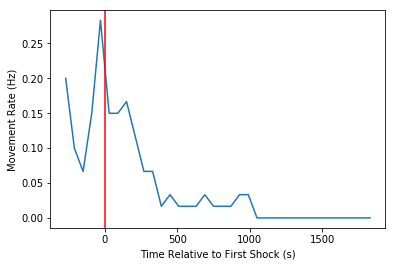

In [7]:
rate_window_starts = np.arange(-300,31*60,60) + f.shock_st[0] #1 minutes windows around start of shock
rate_window_centers = rate_window_starts + 30
rate_windows_adj = rate_window_starts - f.td_time[0] #corrected for the fact that get_movement_rate wants time relative to start of tail imaging.
plt.plot(rate_window_centers - f.shock_st[0], [f.get_movement_rate([x,x+60], bExcShockResp=False) for x in rate_windows_adj])
plt.axvline(0,c='r')
plt.ylabel('Movement Rate (Hz)')
plt.xlabel('Time Relative to First Shock (s)')

The `get_roi_table` method returns a dataframe of all the rois for teh fish.  Each row of this table represents an ROI and specified the place the ROI is in, the pixels that are included in the ROI, the centroid of the ROI, and which brain regions the ROI is in.  

Note, this data is older and was processed by simply segmenting the anatomical images.  Thus the data is does not look as clean as data that is cleaned up and processed using CNMF, for example.

In [8]:
df = f.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01555,0,0,1,"[[1, 27], [1, 28], [2, 26], [2, 27], [2, 28], ...",2.200000,27.200000,10,0.909091,0.828852,...,False,False,False,False,False,False,False,other,w,other
1,f01555,0,1,2,"[[1, 56], [1, 57], [1, 58], [1, 59], [1, 60], ...",1.923077,57.692308,13,1.000000,0.774346,...,False,False,False,False,False,False,False,other,w,other
2,f01555,0,2,3,"[[1, 61], [1, 62], [1, 64], [1, 65], [2, 62], ...",2.076923,63.461538,13,0.764706,0.872165,...,False,False,False,False,False,False,False,other,w,other
3,f01555,0,3,4,"[[1, 83], [1, 84], [1, 85], [1, 86], [2, 82], ...",2.076923,84.384615,13,0.928571,0.656671,...,False,False,False,False,False,False,False,other,w,other
4,f01555,0,4,5,"[[1, 87], [1, 88], [1, 89], [1, 90], [1, 91], ...",3.517857,90.446429,56,0.767123,0.888139,...,False,False,False,False,False,False,False,l_wholebrain,l,wholebrain


'get_signals_raw' returns a matrix containing the raw fluorescent signal associated with each ROI.  Each row of this matrix is associated with the corresponding row of the ROI table.  

Note, I only use the second half of the signal matrix, because the agarose had not fully hardened during the first of imaging which cause the fish to drift in z slightly.

In [10]:
M = f.get_signals_raw(z=None)
#M = hbutils.df_over_f(M)
print 'Num ROIs:', df.shape[0]
print 'Shape of signal matrix', M.shape

Num ROIs: 15888
Shape of signal matrix (15888, 2826)


There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

(**This won't work on AWS unless you upload tif stacks**)

In [12]:
z=8

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
coords = df[(df.in_r_raphe) & (df.z==z)].coords

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

IOError: [Errno 2] No such file or directory: '/data2/Data/MPzfish/drn_hb/f01555/f01555_plane9_rasl.tif'